### 5.2 Dataset (首先运行这部分来准备数据集)

In [ ]:
from google.colab import drive
import os

# 挂载Google Drive
drive.mount('/content/drive')

# 创建数据目录并解压图片
# 确保你的云端硬盘路径正确
celeba_zip_path = "/content/drive/MyDrive/img_align_celeba.zip"
if os.path.exists(celeba_zip_path):
    print("Unzipping CelebA images...")
    !mkdir -p ./data/celeba
    !unzip -q "{celeba_zip_path}" -d ./data/celeba/
    print("Done.")
else:
    print(f"Warning: CelebA zip file not found at {celeba_zip_path}")

# 复制属性文件
print("Copying attribute files...")
!cp "/content/drive/MyDrive/celeba/list_attr_celeba.txt" ./data/celeba/
!cp "/content/drive/MyDrive/celeba/list_eval_partition.txt" ./data/celeba/
print("Done.")

# 验证文件是否存在
print("\nFiles in ./data/celeba/:")
!ls ./data/celeba

Mounted at /content/drive
Unzipping CelebA images...
Done.
Copying attribute files...
Done.

Files in ./data/celeba/:
img_align_celeba  list_attr_celeba.txt	list_eval_partition.txt


### 1. 安装和导入库 (Install and Import Data)

In [ ]:
!pip install torchvision ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install diffusers transformers einops accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 110.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch.nn.functional as F
from torch.utils.data import Dataset
import random
from diffusers import AutoencoderKL
from torchvision.utils import make_grid
import torchvision.utils as vutils
from tqdm.auto import tqdm
from typing import Callable
import os
import pandas as pd
from typing import Tuple, List
import clip
from torchvision.transforms import ToPILImage
from tqdm import trange

In [ ]:
!pip install facenet-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 112.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 102.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 112.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 95.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

In [ ]:
from facenet_pytorch import InceptionResnetV1

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### 2. 模型加载 (Model Loading)
这部分加载预训练的VAE，CLIP和用于Identity Loss的ArcFace模型。

2.1 VAE: AutoencoderKL

In [ ]:
#AutoencoderKL
vae = AutoencoderKL.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="vae").to(device)
vae.eval()

# 图像预处理
transform = transforms.Compose([
    transforms.CenterCrop(178),
    transforms.Resize(256),  # VAE在256x256上效果更好
    transforms.ToTensor(),
])

# 编码器：图像 -> 潜变量
def encode_batch(imgs):
    x = imgs * 2 - 1
    with torch.no_grad():
        dist = vae.encode(x.to(device)).latent_dist
        # 去掉乘以scaling_factor
        z = dist.sample()
    return z

# 解码器：潜变量 -> 图像
def decode_latent(z):
    # 去掉除以scaling_factor
    # z_in = z / vae.config.scaling_factor
    #with torch.no_grad():
        # 直接使用z
    out = vae.decode(z).sample
    img = (out / 2 + 0.5).clamp(0, 1)
    return img

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

2.2 Pretrained CLIP

In [ ]:
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
clip_model.eval()

# CLIP的图像预处理是固定的224x224
clip_img_preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
])

# 获取图像和文本的CLIP特征
def get_clip_features(image_tensor, text_prompt):
    # 为图像获取特征
    image_features = clip_model.encode_image(clip_img_preprocess(image_tensor).to(device))
    image_features = F.normalize(image_features, dim=-1)

    # 为文本获取特征
    text_tokens = clip.tokenize(text_prompt).to(device)
    text_features = clip_model.encode_text(text_tokens)
    text_features = F.normalize(text_features, dim=-1)

    return image_features, text_features

100%|███████████████████████████████████████| 338M/338M [00:10<00:00, 34.1MiB/s]


2.3 Identity Loss Model (ArcFace)

In [ ]:
# 加载预训练的ArcFace模型用于身份损失
arcface_model = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# ArcFace的图像预处理
arcface_preprocess = transforms.Compose([
    transforms.Resize(160)
])

# 定义身份损失函数
def identity_loss(source_img, edited_img):
    # 我们只希望阻止对source_img的梯度计算
    with torch.no_grad():
        source_emb = arcface_model(arcface_preprocess(source_img))

    # 对于edited_img，我们需要计算梯度
    edited_emb = arcface_model(arcface_preprocess(edited_img))

    # 计算余弦相似度损失
    return 1 - F.cosine_similarity(source_emb, edited_emb).mean()

  0%|          | 0.00/107M [00:00<?, ?B/s]

### 3. Latent Optimization

3.1 准备少量数据集
我们不再加载整个数据集，而是随机挑选5张不带"Smiling"属性的图片。

In [ ]:
def sample_attr_paths(root: str, attr_name: str, N: int, positive: bool = True) -> List[str]:
    attr_path = os.path.join(root, 'list_attr_celeba.txt')
    img_dir   = os.path.join(root, 'img_align_celeba')

    df = pd.read_csv(attr_path, sep='\s+', header=1, index_col=0)

    target_val = 1 if positive else -1
    sub_df = df[df[attr_name] == target_val]

    if len(sub_df) < N:
        raise ValueError(f"not enough {N} samples for {attr_name}={target_val}")

    file_list = random.sample(list(sub_df.index), N)
    paths = [os.path.join(img_dir, fn) for fn in file_list]
    return paths

class SimpleCelebA(Dataset):
    def __init__(self, paths: List[str], transform):
        self.paths = paths
        self.transform = transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        return self.transform(img)

# --- 参数设置 ---
DATASET_ROOT = './data/celeba'
ATTRIBUTE_TO_EDIT = 'Smiling' # 我们要编辑的属性
N_SAMPLES = 2 # 选择5张图片作为示例
BATCH_SIZE = 1 # 一次处理一张图片

# 获取5张不带"Smiling"属性的图片
source_paths = sample_attr_paths(DATASET_ROOT, ATTRIBUTE_TO_EDIT, N_SAMPLES, positive=False)
source_loader = DataLoader(SimpleCelebA(source_paths, transform), batch_size=BATCH_SIZE, shuffle=False)

print(f"Loaded {len(source_paths)} images without the '{ATTRIBUTE_TO_EDIT}' attribute for editing.")

Loaded 2 images without the 'Smiling' attribute for editing.


3.2 Latent Optimization 核心函数
这是论文中描述的优化循环的实现。

In [ ]:
def latent_optimization_edit(
    source_img,
    text_prompt,
    l2_lambda=0.008,
    id_lambda=0.005,
    steps=300,
    lr=0.01
):
    # 1. 获取原始潜变量
    z_s = encode_batch(source_img)
    z_s.requires_grad = False

    # 2. 初始化待优化的潜变量
    z_editable = z_s.clone()
    z_editable.requires_grad = True
    print(z_s.device, z_editable.device)

    # 3. 设置优化器
    optimizer = torch.optim.Adam([z_editable], lr=lr)

    print(f"Optimizing for text prompt: '{text_prompt}'...")
    pbar = range(steps)
    for step in pbar:
        optimizer.zero_grad()

        # 从当前潜变量解码出新图片
        edited_img = decode_latent(z_editable)

        # 计算损失
        img_feats, txt_feats = get_clip_features(edited_img, text_prompt)
        clip_loss = 1 - torch.cosine_similarity(img_feats, txt_feats).mean()
        l2_loss = F.mse_loss(z_editable, z_s)
        id_loss = identity_loss(source_img, edited_img)
        total_loss = clip_loss + l2_lambda * l2_loss + id_lambda * id_loss

        # 仅每隔20步输出一次 debug 信息
        if step % 20 == 0 or step == steps - 1:
            # 潜变量的平均变化幅度
            latent_diff = (z_editable - z_s).abs().mean().item()
            print(
                f"[step {step}] total_loss={total_loss.item():.4f} "
                f"clip_loss={clip_loss.item():.4f} "
                f"l2_loss={l2_loss.item():.4f} "
                f"id_loss={id_loss.item():.4f} "
                f"latent_diff={latent_diff:.6f} "
                f"img min/max={edited_img.min().item():.3f}/{edited_img.max().item():.3f}"
            )

        # 反向传播和优化
        total_loss.backward()
        optimizer.step()

    return z_editable


def compare_reconstruction(img_orig, img_recon, img_edited, n=5):
    img_orig = img_orig.cpu()
    img_recon = img_recon.cpu()
    img_edited = img_edited.cpu()

    plt.figure(figsize=(n*3, 9))
    for i in range(n):
        plt.subplot(3, n, i+1)
        plt.imshow(img_orig[i].permute(1,2,0).numpy().clip(0,1))
        plt.axis('off')
        if i == 0: plt.title('Original')

        plt.subplot(3, n, n+i+1)
        plt.imshow(img_recon[i].detach().permute(1,2,0).numpy().clip(0,1))
        plt.axis('off')
        if i == 0: plt.title('VAE Recon')

        plt.subplot(3, n, 2*n+i+1)
        plt.imshow(img_edited[i].detach().permute(1,2,0).numpy().clip(0,1))
        plt.axis('off')
        if i == 0: plt.title('Edited')
    plt.show()

3.3 执行编辑并可视化结果

cuda:0 cuda:0
Optimizing for text prompt: 'laughing face'...
[step 0] total_loss=0.7550 clip_loss=0.7549 l2_loss=0.0000 id_loss=0.0150 latent_diff=0.000000 img min/max=0.000/1.000
[step 20] total_loss=0.7142 clip_loss=0.7139 l2_loss=0.0279 id_loss=0.0279 latent_diff=0.157377 img min/max=0.000/1.000
[step 40] total_loss=0.6869 clip_loss=0.6860 l2_loss=0.0802 id_loss=0.0370 latent_diff=0.256470 img min/max=0.000/1.000
[step 60] total_loss=0.6664 clip_loss=0.6650 l2_loss=0.1400 id_loss=0.0400 latent_diff=0.329257 img min/max=0.000/1.000
[step 80] total_loss=0.6493 clip_loss=0.6475 l2_loss=0.2078 id_loss=0.0409 latent_diff=0.394270 img min/max=0.000/1.000
[step 100] total_loss=0.6329 clip_loss=0.6304 l2_loss=0.2816 id_loss=0.0471 latent_diff=0.452886 img min/max=0.000/1.000
[step 120] total_loss=0.6212 clip_loss=0.6182 l2_loss=0.3508 id_loss=0.0478 latent_diff=0.500825 img min/max=0.000/1.000
[step 140] total_loss=0.6120 clip_loss=0.6084 l2_loss=0.4188 id_loss=0.0440 latent_diff=0.542037 i

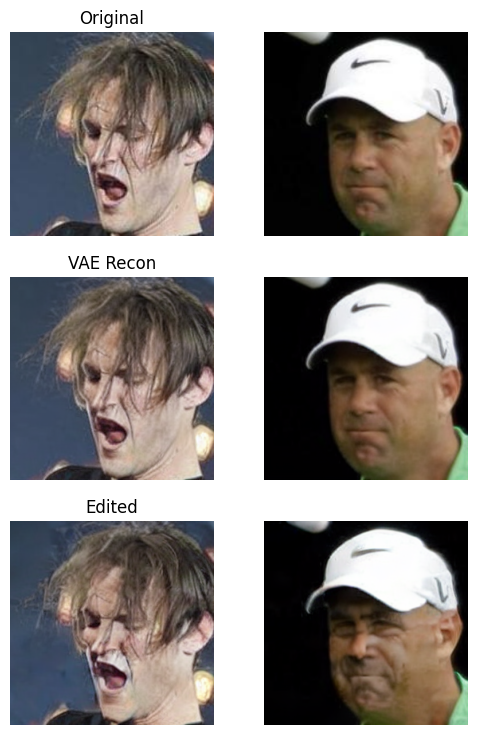

In [ ]:
TARGET_PROMPT = "laughing face"
LAMBDA_L2 = 0.008  # 来自论文的参数 [cite: 140, 146, 147]
LAMBDA_ID = 0.005  # 来自论文的参数 [cite: 140, 146, 147]

original_images = []
recon_images = []
edited_images = []

for i, source_batch in enumerate(source_loader):
    if i >= N_SAMPLES:
        break

    source_img_tensor = source_batch.to(device)

    # 执行优化
    edited_latent = latent_optimization_edit(
        source_img=source_img_tensor,
        text_prompt=TARGET_PROMPT,
        l2_lambda=LAMBDA_L2,
        id_lambda=LAMBDA_ID,
        steps=200,
        lr=0.01
    )

    # 解码出最终结果
    original_img = source_img_tensor
    recon_img = decode_latent(encode_batch(original_img))
    edited_img = decode_latent(edited_latent)

    # 每张图输出最终 latent diff 检查
    latent_orig = encode_batch(original_img)
    latent_diff_final = (edited_latent - latent_orig).abs().mean().item()
    print(f"[IMAGE {i}] final latent mean abs diff: {latent_diff_final:.6f}")
    print(f"[IMAGE {i}] original_img min/max: {original_img.min().item():.3f}/{original_img.max().item():.3f}")
    print(f"[IMAGE {i}] recon_img min/max: {recon_img.min().item():.3f}/{recon_img.max().item():.3f}")
    print(f"[IMAGE {i}] edited_img min/max: {edited_img.min().item():.3f}/{edited_img.max().item():.3f}")

    #original_images.append(original_img)
    #recon_images.append(recon_img)
    #edited_images.append(edited_img)
    # 这里用 .detach().cpu() 防止占用显存
    original_images.append(original_img.detach().cpu())
    recon_images.append(recon_img.detach().cpu())
    edited_images.append(edited_img.detach().cpu())

    # 释放无用显存
    del edited_latent, original_img, recon_img, edited_img
    torch.cuda.empty_cache()

original_images = torch.cat(original_images, dim=0)
recon_images = torch.cat(recon_images, dim=0)
edited_images = torch.cat(edited_images, dim=0)


# 可视化对比
print("\nDisplaying results...")
compare_reconstruction(original_images, recon_images, edited_images, n=N_SAMPLES)